In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [36]:
# Units in inches
heightOffGround = 9
rInner = 5
lenRod = 18.5
rOuter = lenRod - rInner
rCenter = lenRod/2
numMotors = 4
numFeet = numMotors*2
motorAngle = 360/float(numFeet)
angleBetween = 360/float(numFeet)
rCurveFeet = 4
# Encoder steps per inch
motorScale = 1  # Find what value this actually is
minLiftAngle = 25  # 15 to 20 according to Anthony

In [24]:
footPoints = np.array([
        0
    ])
def calcPositionPoints(angle, motors):
    assert len(motors) == numMotors, "Wrong number of motors"
    pointsPerMotor = 3
    ppm = pointsPerMotor
    points = np.zeros((pointsPerMotor*numMotors,2))
    for i in xrange(numMotors):
        a = np.deg2rad(angle+i*motorAngle+90)
        r1 = rCenter + motors[i]/float(motorScale)
        r2 = rCenter - motors[i]/float(motorScale)
        assert rInner <= r1 <= rOuter and rInner <= r2 <= rOuter, "Motor out of bounds"
        points[i*ppm] = np.array((r1*np.cos(a),r1*np.sin(a)))
        points[i*ppm+1] = np.array((-r2*np.cos(a),-r2*np.sin(a)))
        points[i*ppm+2] = np.array((np.NaN, np.NaN))
        #points[i*ppm+3:i*ppm+3+len(footPoints)] = footPoints
        #points[i*ppm+3+len(footPoints)] = np.array((np.NaN, np.NaN))
    return points

In [25]:
def drawPosition(angle, motors):
    points = calcPositionPoints(angle, motors)
    plt.plot(*points.T)
    plt.plot([0,15*np.cos(np.deg2rad(angle+90))], [0,15*np.sin(np.deg2rad(angle+90))], 'g:')
    a = rOuter*1.1
    plt.plot([-a, a], [-heightOffGround, -heightOffGround], 'r:')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim([-a,a])
    plt.ylim([-a,a])

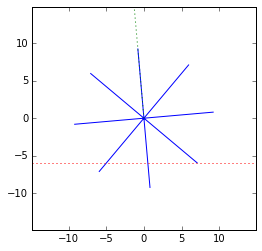

In [26]:
drawPosition(5, [0,0,0,0])

In [27]:
def domainAndOffset(angle):
    domain = int(((360-angle+angleBetween/2.0)/(angleBetween)) % numFeet)
    offset = (angle+domain*angleBetween-360) % 360
    #domain = ((360-angle+angleBetween/2.0)/(angleBetween)) % numFeet
    return (domain,offset)

In [28]:
# Actual trig calculations here
def calcPositionsFromOffset(offset):
    h = heightOffGround
    t_0 = np.deg2rad(offset)
    t_1 = np.deg2rad(offset+45)
    t_nm1 = np.deg2rad(offset-45)
    x_0 = rCurveFeet*(1-np.cos(t_0))
    x_1 = rCurveFeet*(1-np.cos(t_1))
    x_nm1 = rCurveFeet*(1-np.cos(t_nm1))
    a_0 = (h-x_0)/np.cos(t_0)
    a_1 = (h-x_1)/np.cos(t_1)
    a_nm1 = (h-x_nm1)/np.cos(t_nm1)
    motors = [0]*numMotors
    motors[0] = (rCenter-a_0)
    motors[1] = (rCenter-a_1)
    motors[-1] = (a_nm1-rCenter)
    for i in xrange(len(motors)):
        if motors[i] > rOuter-rCenter:
            motors[i] = rOuter-rCenter
        if motors[i] < -(rOuter-rCenter):
            motors[i] = -(rOuter-rCenter)
        motors[i] = motors[i] * motorScale
    return motors

In [29]:
def calcPositions(angle):
    domain, offset = domainAndOffset(angle)
    motorsDomain = calcPositionsFromOffset(offset)
    motors = [0]*len(motorsDomain)
    for i, md in zip(xrange(len(motorsDomain)), motorsDomain):
        motors[(i+domain)%numMotors] = md if (i+domain)%numFeet < numMotors else -md
    return motors

[3.2423603249133048, 2.1385523462791758, 0, -2.6391854213354433]

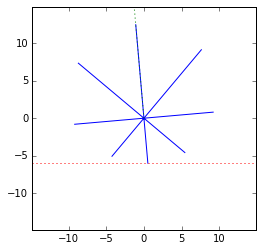

In [30]:
angle = 5
drawPosition(angle, calcPositions(angle))
calcPositions(angle)

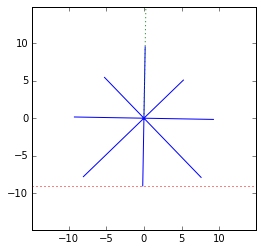

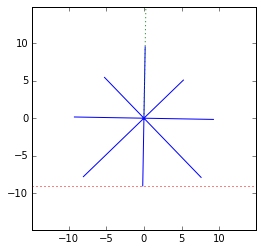

In [38]:
for angle in xrange(0,720,1):
    plt.clf()
    drawPosition(angle, calcPositions(angle+0))
    display.clear_output(wait=True)
    display.display(plt.gcf())